<a href="https://colab.research.google.com/github/valmeau/w07-final-project/blob/master/bvh_exploratory_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W207 - Forest Cover Type Prediction

## Final Project Baseline

## Team:
- Brittney Van Hese
- Prabhaker Narsina
- Valérie Méausoone


### Setting up our environment

In [73]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 
from sklearn.preprocessing import StandardScaler

%matplotlib inline

### Exploratory Data Analysis
We perform an EDA on the training dataset provided by the Kaggle competition.

#### Importing the data

In [74]:
train_df = pd.read_csv('input/train.csv', index_col='Id')
col_names = train_df.columns.tolist()

print("Column names:")
print(col_names)

print("\nSample data:")
train_df.head()

Column names:
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']

Sample data:


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
2,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
3,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
4,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
5,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [75]:
# Isolate target data
cover_type = train_df['Cover_Type']
y = np.array(cover_type)

# Dropping output from feature space
to_drop = ['Cover_Type']
cover_feat_space = train_df.drop(to_drop, axis = 1)

# Pull out geatures for future use
features = cover_feat_space.columns
X = np.array(cover_feat_space).astype(np.float)

print("Feature space hold %d observations and %d features" % X.shape)
print("Unique target labels:", np.unique(y))

Feature space hold 15120 observations and 54 features
Unique target labels: [1 2 3 4 5 6 7]


#### Assessing quality of data

In [76]:
# Assessing missingness
print("There are", np.count_nonzero(np.isnan(X)), "missing values among our features")
print("There are", np.count_nonzero(np.isnan(y)), "missing values among our target values")

#Assessing plausibility of values
print("\nLooking at summary statistics for our training data:")
train_df.describe()

There are 0 missing values among our features
There are 0 missing values among our target values

Looking at summary statistics for our training data:


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,...,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,...,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,1988.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
max,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,6993.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


The variables all have plausible distributions. We notice a negative minimum for "Vertical_Distance_To_Hydrology" but understand that it is plausible if the reference point is above that minimum value. 

#### Feature and target plots

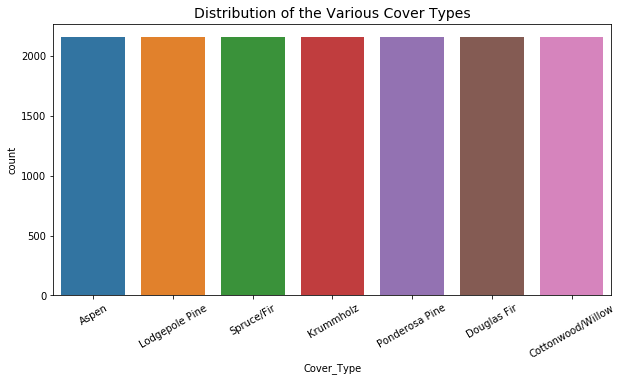

In [77]:
#Plotting the target
#Renaming the target labels to make them more meaningful
train_df['Cover_Type'].replace({1:'Spruce/Fir', 2: 'Lodgepole Pine', 3: 'Ponderosa Pine', 4: 'Cottonwood/Willow', 5: 'Aspen', 6: 'Douglas Fir', 7: ' Krummholz'}, inplace=True)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Distribution of the Various Cover Types", size = 14)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax = sns.countplot(x = "Cover_Type", data = train_df)

<Figure size 1152x576 with 0 Axes>

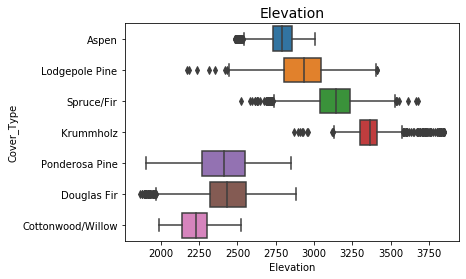

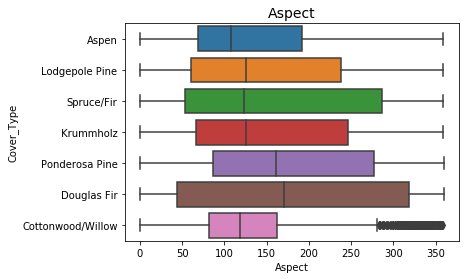

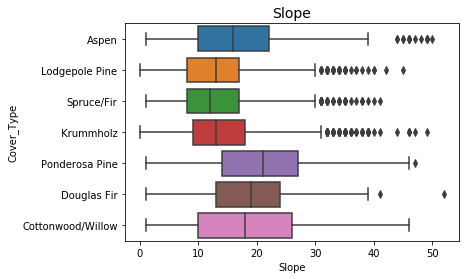

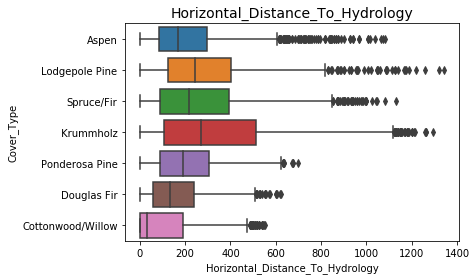

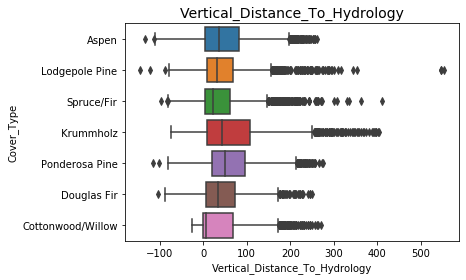

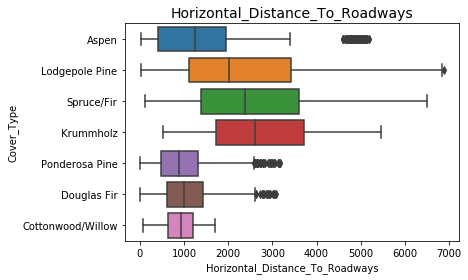

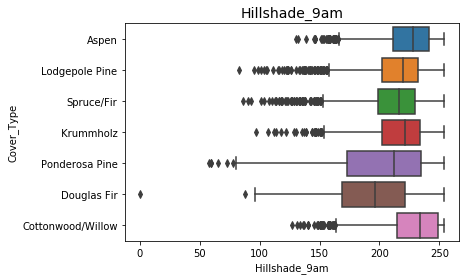

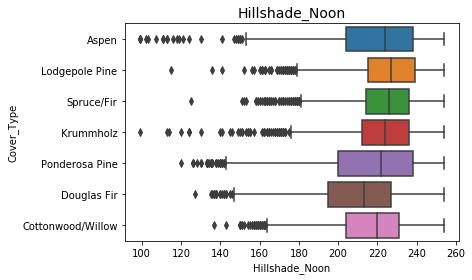

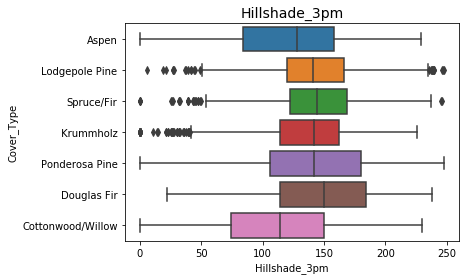

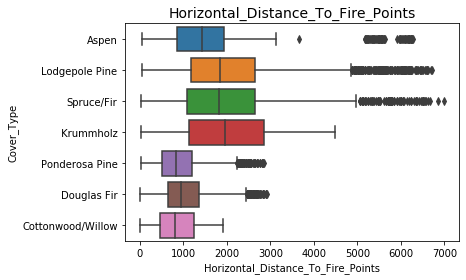

In [78]:
#Plotting and grouping numerical features according to target classes
plt.figure(figsize=(16, 8))

num_values_range = 10
# Iterate over the features, creating a subplot with a histogram for each one.
for feature in range(num_values_range):
    fig1, ax1 = plt.subplots()
    ax1.set_title(train_df.columns[feature], size = 14)
    ax1 = sns.boxplot(x = train_df.columns[feature], y = 'Cover_Type' , data = train_df)

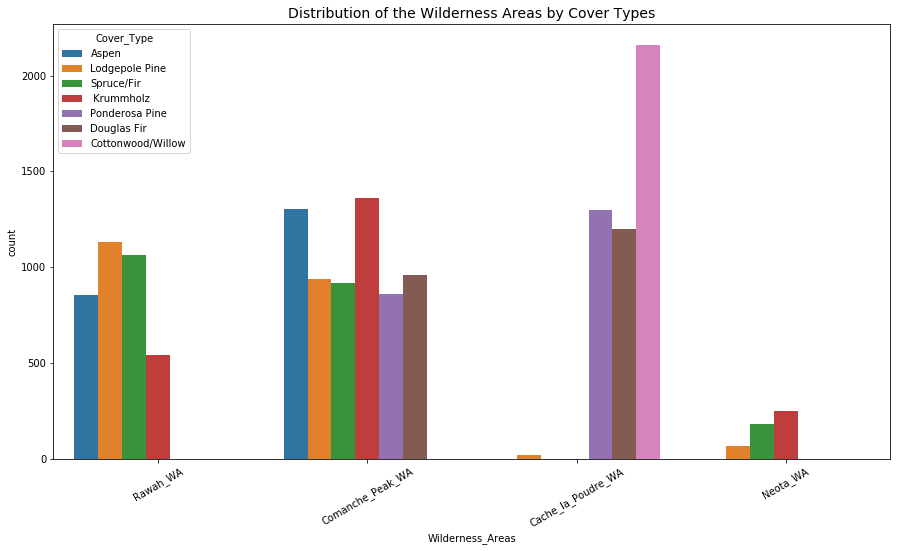

In [79]:
#Plotting catgorical features
#Transform binary into a few categorical variables, and giving them more meaningful names where possible
train_df = train_df.rename(columns={"Wilderness_Area1":"Rawah_WA","Wilderness_Area2":"Neota_WA",
"Wilderness_Area3":"Comanche_Peak_WA","Wilderness_Area4":"Cache_la_Poudre_WA"})
train_df['Wilderness_Areas'] = (train_df.iloc[:,10:14] == 1).idxmax(1)

fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("Distribution of the Wilderness Areas by Cover Types", size = 14)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax = sns.countplot(x = "Wilderness_Areas", hue = "Cover_Type", data = train_df)

In [80]:
train_df['Soil_Type'] = (train_df.iloc[:,15:55] == 1).idxmax(1)
fig = px.histogram(train_df, x="Soil_Type", color="Cover_Type", title='Distribution of the Soil Types by Cover Types',)
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})

fig.show()

#### Covariance Matrix

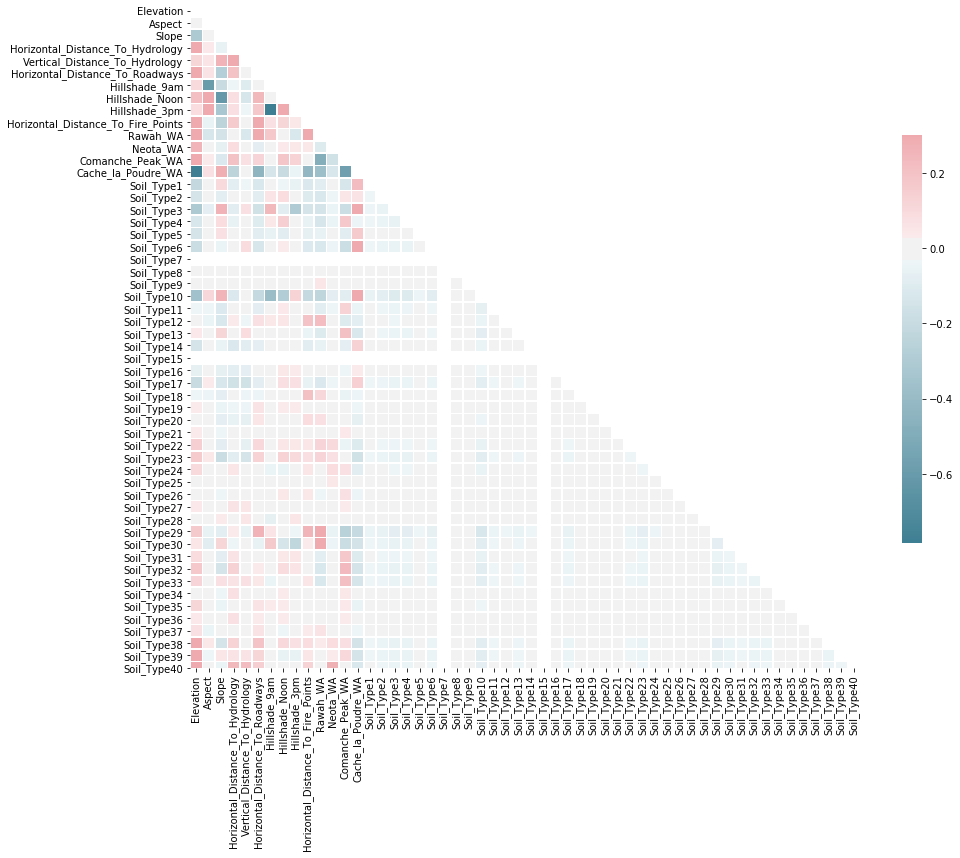

In [81]:
# Compute the correlation matrix
corr = train_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Prabhu's Changes start here

In [82]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [165]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from  sklearn.metrics import classification_report
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

def display_CrossValidation_class_level_ROCcharts(y_true, y_predict, label_classes):
# ################################################################################
# This function is implemented to display each class level Cross Validation chart
# y_true: Truth data given for lable
# y_predict:  Predicted labels from Machine learning models
# label_Classes: All the labels_class we are trying to predict
# #################################################################################
    fig = plt.figure(figsize=(14,12))
    plt.tight_layout()

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
 
    lw = 2

    for i in range(len(label_classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_predict[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        sp = fig.add_subplot(3, 3, i+1)
        sp.set_title('cover_class ' + str( label_classes[i]))
        plt.plot(fpr[i], tpr[i], color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
    plt.show() 


def ml_pipleline(ml_name, model,   param_grid = None,  binarize = False, detailedCVcharts = False):
# ##########################################################################################
# This pipeline funciton is define to centralize Machine Learning pipe line for this project
# ml_name - descriptive name, that can be used for printing
# moddel - Machine Learning Model object like KNN, Logistic or NB
# X_train: Training data
# y_train: label data from training
# X_validation:  Validation data
# y_valid: Label for validation data
# binarize: Some of the Machine Learning models requires binarization and some doesn't
# detailedCVcharts:  This to see details at each class level or not.
# 70% train, 30% test
# ############################################################################################
# 
    cv = 10
    pca = PCA()
    lable_classes = classes=[1, 2, 3,4,5,6,7]

    scalar = StandardScaler()
    
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.3, random_state=17)
    scalar.fit(X_train)
    X_train = scalar.transform(X_train)
    X_valid = scalar.transform(X_valid)


    gsearch = GridSearchCV(model, param_grid, n_jobs=2)
    
    gsresults = gsearch.fit(X_train, y_train)

    y_predict = gsearch.predict(X_valid)
    report = classification_report(y_predict, y_valid)
  
    print(color.BOLD, ml_name, color.END, '\n')
    print('Metrics: \n ', report)
    
    print(gsresults)

    print("Best score (CV score=%0.3f):" % gsearch.best_score_)
    print("Best parameters" ,gsearch.best_params_)

    # Plot the PCA spectrum
    pca.fit(X_train)

    fig = plt.figure(figsize=(6, 6))
    plt.plot(np.arange(1, pca.n_components_ + 1),
             pca.explained_variance_ratio_, '+', linewidth=2)
    plt.set_ylabel('PCA explained variance ratio')

    plt.show

    print(model.get_params())
    if detailedCVcharts:
        display_CrossValidation_class_level_ROCcharts(y_valid, y_predict,lable_classes)
        
    return(report, y_predict)

In [ ]:
param_grid = {}
param_grid['n_neighbors'] = [1,3,5,7,9]
param_grid['weights'] =  ['uniform', 'distance']
param_grid['p'] =  [1,2,3,4]
param_grid['algorithm'] =  ['auto', 'ball_tree', 'kd_tree', 'brute']
param_grid['leaf_size'] =  [20,30,40]

%time
knn_classifier = KNeighborsClassifier()
# KNeighborsClassifier.get_params().keys()
report, y_predict = ml_pipleline('KNN with GS ', knn_classifier,  param_grid=param_grid )
print('final_report',report)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

